In [1]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pickle
import math
import torch.nn.init as init

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.io import read_image
from torchvision.utils import save_image
import matplotlib.pyplot as plt

In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
from torchvision.transforms import Lambda
both_transform = A.Compose([A.Resize(width=256, height=256),], additional_targets={"image0": "image"},)
transform = A.Compose([A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),ToTensorV2(),])
class GroundTruthNoisyDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.folders = os.listdir(self.root_dir)

    def __len__(self):
        return len(self.folders)

    def __getitem__(self, idx):
        folder_name = self.folders[idx]
        ground_truth_path = os.path.join(self.root_dir, folder_name, "gt.jpg")
        noisy_path = os.path.join(self.root_dir, folder_name, "noise.jpg")
        ground_truth = np.array(Image.open(ground_truth_path))
        noisy = np.array(Image.open(noisy_path))
        augmentations = both_transform(image=noisy, image0=ground_truth)
        noisy = augmentations["image"]
        ground_truth = augmentations["image0"]
        ground_truth = transform(image = ground_truth)["image"]
        noisy = transform(image = noisy)["image"]
        return noisy, ground_truth

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
def save_some_examples(gen, val_loader, epoch, folder):
    x, y = next(iter(val_loader))
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    x, y = x.to(DEVICE), y.to(DEVICE)
    if not os.path.exists(folder):
        os.makedirs(folder)
    gen.eval()
    with torch.no_grad():
        y_fake = gen(x)
        y_fake = y_fake * 0.5 + 0.5  # remove normalization#
        save_image(y_fake, folder + f"/y_gen_{epoch}.png")
        save_image(x * 0.5 + 0.5, folder + f"/input_{epoch}.png")
        if epoch == 1:
            save_image(y * 0.5 + 0.5, folder + f"/label_{epoch}.png")
    gen.train()

In [5]:
root_tr = "/kaggle/input/256-256-image-denoising-benchmark/Image_Denoising_Data_256/Train"
root_te = "/kaggle/input/256-256-image-denoising-benchmark/Image_Denoising_Data_256/Test"

In [6]:
train_dataset = GroundTruthNoisyDataset(root_tr)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

valid_dataset = GroundTruthNoisyDataset(root_te)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [7]:
#!/usr/bin/env python

import torch
import torch.nn as nn
import torch.nn.functional as F


# Denoise DND and NAM
class UNet_ND(nn.Module):

    def __init__(self):
        super(UNet_ND, self).__init__()
        self.main = MainNet(in_nc=3, out_nc=12)
        self.main2 = MainNet(in_nc=15, out_nc=24)
        self.out = nn.Conv2d(24, 3, kernel_size=3, padding=1, bias=True)

    def forward(self, x):
        out1 = self.main(x)
        out1[:,:3,:,:] = out1[:,:3,:,:] + x
        out2 = self.main2(torch.cat([x, out1], dim=1))
        out2[:, :3, :, :] = out2[:, :3, :, :] + x
        out2[:, 12:, :, :] = out2[:, 12:, :, :] + out1

        return self.out(out2) + x

class UNet_D(nn.Module):

    def __init__(self):
        super(UNet_D, self).__init__()
        self.main = MainNet(in_nc=3, out_nc=12)
        self.main2 = MainNet(in_nc=15, out_nc=24)
        self.out = nn.Conv2d(24, 3, kernel_size=3, padding=1, bias=True)

    def forward(self, x):
        out1 = self.main(x)
        out1[:,:3,:,:] = out1[:,:3,:,:] + x
        out2 = self.main2(torch.cat([x, out1], dim=1))
        out2[:, :3, :, :] = out2[:, :3, :, :] + x
        out2[:, 12:, :, :] = out2[:, 12:, :, :] + out1

        return self.out(out2) + x

class HI_GAN(nn.Module):
    def __init__(self, ):
        super(HI_GAN, self).__init__()
        self.main = MainNet(in_nc=6, out_nc=6)
        self.main2 = MainNet(in_nc=12, out_nc=12)
        self.main3 = MainNet(in_nc=24, out_nc=24)
        self.out = nn.Conv2d(24, 3, kernel_size=3, padding=1, bias=True)
    def forward(self, unet_nd_dn, unet_d_dn):
        concat_img1 = torch.cat([unet_nd_dn, unet_d_dn], dim=1)
        out1 = 0.2*self.main(concat_img1) + concat_img1

        concat_img2 = torch.cat([concat_img1, out1], dim=1)
        out2 = 0.2*self.main2(concat_img2) + concat_img2

        concat_img3 = torch.cat([concat_img2, out2], dim=1)
        out3 = 0.2*self.main3(concat_img3) + concat_img3

        out = 0.2 * self.out(out3) + 0.5 * unet_nd_dn + 0.5 * unet_d_dn
        return out

# Denoise Cell
class UNet_ND_cell(nn.Module):

    def __init__(self):
        super(UNet_ND_cell, self).__init__()
        self.main = MainNet(in_nc=1, out_nc=1)
        self.main2 = MainNet(in_nc=2, out_nc=2)
        self.out = nn.Conv2d(4, 1, kernel_size=3, padding=1, bias=True)

    def forward(self, x):
        out1 = self.main(x) + x
        cat1 = torch.cat([x, out1], dim=1)
        out2 = self.main2(cat1) + cat1
        cat2 = torch.cat([x,out1, out2], dim=1)
        return self.out(cat2) + x

class UNet_D_cell(nn.Module):

    def __init__(self):
        super(UNet_D_cell, self).__init__()
        self.main = MainNet(in_nc=1, out_nc=1)
        self.main2 = MainNet(in_nc=2, out_nc=2)
        self.out = nn.Conv2d(4, 1, kernel_size=3, padding=1, bias=True)

    def forward(self, x):
        out1 = self.main(x) + x
        cat1 = torch.cat([x, out1], dim=1)
        out2 = self.main2(cat1) + cat1
        cat2 = torch.cat([x,out1, out2], dim=1)
        return self.out(cat2) + x

class HI_GAN_cell(nn.Module):
    def __init__(self, ):
        super(HI_GAN_cell, self).__init__()
        self.main = MainNet(in_nc=2, out_nc=2)
        self.main2 = MainNet(in_nc=4, out_nc=4)
        self.main3 = MainNet(in_nc=8, out_nc=8)
        self.out = nn.Conv2d(8, 1, kernel_size=3, padding=1, bias=True)
    def forward(self, unet_nd_dn, unet_d_dn):
        cat1 = torch.cat([unet_nd_dn, unet_d_dn], dim=1)
        out1 = 0.2*self.main(cat1) + cat1

        cat2 = torch.cat([cat1, out1], dim=1)
        out2 = 0.2*self.main2(cat2) + cat2

        cat3 = torch.cat([cat2, out2], dim=1)
        out3 = 0.2*self.main3(cat3) + cat3

        out = 0.2 * self.out(out3) + 0.5 * unet_nd_dn + 0.5 * unet_d_dn
        return out


## Sub classes
class MainNet(nn.Module):
    """B-DenseUNets"""
    def __init__(self, in_nc=12, out_nc=12):
        super(MainNet, self).__init__()
        self.inc = nn.Sequential(
            single_conv(in_nc, 64),
            single_conv(64, 64),
        )
        self.down1 = nn.AvgPool2d(2)
        self.conv1 = nn.Sequential(
            single_conv(64, 128),
            RDB(128, 4, 32),
        )
        self.down2 = nn.AvgPool2d(2)
        self.conv2 = nn.Sequential(
            single_conv(128, 256),
            RDB(256, 10, 32),
        )
        self.up1 = up(256)
        self.conv3 = nn.Sequential(
            RDB(128, 6, 32),
        )
        self.up2 = up(128)
        self.conv4 = nn.Sequential(
            RDB(64, 4, 32),
        )
        self.outc = outconv(64, out_nc)
    def forward(self, x):
        inx = self.inc(x)

        down1 = self.down1(inx)
        conv1 = self.conv1(down1)

        down2 = self.down2(conv1)
        conv2 = self.conv2(down2)

        up1 = self.up1(conv2, conv1)
        conv3 = self.conv3(up1)

        up2 = self.up2(conv3, inx)
        conv4 = self.conv4(up2)

        out = self.outc(conv4)
        return out

class single_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(single_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch):
        super(up, self).__init__()
        self.up = nn.ConvTranspose2d(in_ch, in_ch // 2, 2, stride=2)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2))

        x = x2 + x1
        return x

class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


class RDB(nn.Module):
    def __init__(self, nChannels, nDenselayer, growthRate):
        super(RDB, self).__init__()
        nChannels_ = nChannels
        modules = []
        for i in range(nDenselayer):
            modules.append(make_dense(nChannels_, growthRate))
            nChannels_ += growthRate
        self.dense_layers = nn.Sequential(*modules)
        self.conv_1x1 = nn.Conv2d(nChannels_, nChannels, kernel_size=1, padding=0, bias=False)

    def forward(self, x):
        out = self.dense_layers(x)
        out = self.conv_1x1(out)
        out = out + x
        return out

class make_dense(nn.Module):
    def __init__(self, nChannels, growthRate, kernel_size=3):
        super(make_dense, self).__init__()
        self.conv = nn.Conv2d(nChannels, growthRate, kernel_size=kernel_size, padding=(kernel_size - 1) // 2,
                              bias=False)

    def forward(self, x):
        out = F.relu(self.conv(x))
        out = torch.cat((x, out), 1)
        return out


In [8]:
model = UNet_ND()

In [9]:
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

Using 2 GPUs!


In [10]:
import math
import torch.nn as nn
import torch

def psnr(mse, max_pixel_val=255.0):
    return 10 * math.log10(max_pixel_val**2 / mse)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
los = nn.MSELoss()
num_epochs = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
train_losses = []
train_psnr = []
test_losses = []
test_psnr = []


for epoch in range(num_epochs):
    total_psnr_train = 0
    tot_loss_train = 0
    model.train()
    
    optimizer.zero_grad()  # Initialize gradients once at the start of each epoch

    for i, (noisy_imgs, clean_imgs) in enumerate(train_loader):
        noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
        outputs = model(noisy_imgs)
        loss = criterion(outputs, clean_imgs)
        o = outputs*0.5+0.5
        c = clean_imgs*0.5+0.5
        mse = los(o*255.0,c*255.0)
        current_psnr = psnr(mse)
        total_psnr_train += current_psnr
        tot_loss_train += loss.item()  # Using loss.item() to accumulate the loss

        loss.backward()  # Calculate gradients

        optimizer.step()  # Update weights
        optimizer.zero_grad()  # Reset gradients

    avg_psnr_train = total_psnr_train / len(train_loader)
    train_losses.append(tot_loss_train / len(train_loader))
    train_psnr.append(avg_psnr_train)
    model.eval()
    total_psnr_valid = 0
    tot_loss_valid = 0

    with torch.no_grad():
        for noisy_imgs, clean_imgs in valid_loader:
            noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
            outputs = model(noisy_imgs)
            o = outputs*0.5+0.5
            c = clean_imgs*0.5+0.5
            mse = los(o*255.0,c*255.0)
            current_psnr = psnr(mse)
            total_psnr_valid += current_psnr
            tot_loss_valid += loss.item()

    avg_psnr_valid = total_psnr_valid / len(valid_loader)
    test_losses.append(tot_loss_valid / len(valid_loader))
    test_psnr.append(avg_psnr_valid)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train PSNR: {avg_psnr_train:.4f}, Valid PSNR: {avg_psnr_valid:.4f}")
    save_some_examples(model, valid_loader, epoch, folder="/kaggle/working/evaluation")

Epoch [1/100], Train PSNR: 30.8758, Valid PSNR: 33.5779
Epoch [2/100], Train PSNR: 34.2841, Valid PSNR: 34.7147
Epoch [3/100], Train PSNR: 35.1032, Valid PSNR: 35.3841
Epoch [4/100], Train PSNR: 35.4675, Valid PSNR: 35.5766
Epoch [5/100], Train PSNR: 35.7869, Valid PSNR: 35.6043
Epoch [6/100], Train PSNR: 35.9095, Valid PSNR: 36.0621
Epoch [7/100], Train PSNR: 36.2178, Valid PSNR: 35.8784
Epoch [8/100], Train PSNR: 36.3327, Valid PSNR: 36.4766
Epoch [9/100], Train PSNR: 36.4113, Valid PSNR: 36.5104
Epoch [10/100], Train PSNR: 36.5690, Valid PSNR: 36.7096
Epoch [11/100], Train PSNR: 36.5799, Valid PSNR: 36.4763
Epoch [12/100], Train PSNR: 36.6826, Valid PSNR: 36.4843
Epoch [13/100], Train PSNR: 36.6478, Valid PSNR: 36.6004
Epoch [14/100], Train PSNR: 36.7779, Valid PSNR: 36.8323
Epoch [15/100], Train PSNR: 36.8894, Valid PSNR: 36.2812
Epoch [16/100], Train PSNR: 36.7115, Valid PSNR: 36.9121
Epoch [17/100], Train PSNR: 36.8335, Valid PSNR: 36.2862
Epoch [18/100], Train PSNR: 36.8681, Val

In [11]:
train_loss = []
test_loss = []
for i in train_losses:
    train_loss.append(i)
for i in test_losses:
    test_loss.append(i)

In [12]:
print("Train_loss:",train_loss[len(train_loss)-1])
print("Test_loss:",test_loss[len(test_loss)-1])

Train_loss: 0.0007643019168454251
Test_loss: 0.0010063473600894213


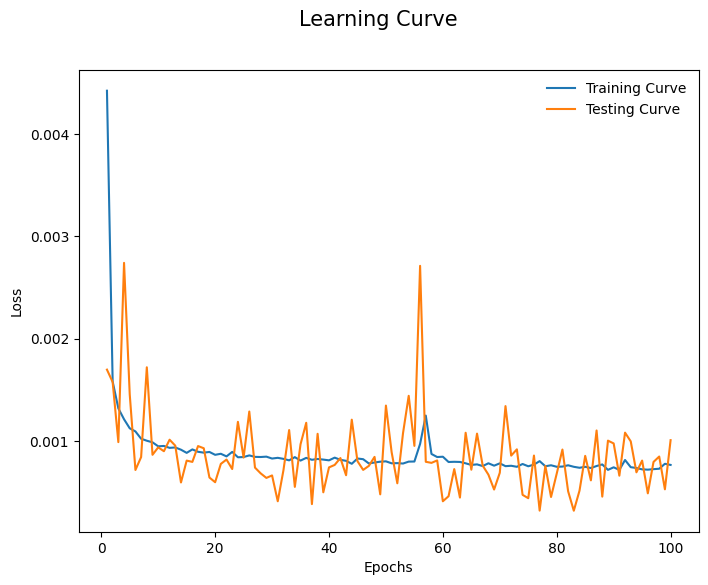

In [13]:
import matplotlib.pyplot as plt
x = [i for i in range(1,101)]
fig, ax = plt.subplots(1, figsize=(8,6))
fig.suptitle("Learning Curve", fontsize = 15)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.plot(x, train_loss, label="Training Curve")
ax.plot(x, test_loss, label="Testing Curve")
plt.legend(loc="upper right", frameon=False)
plt.show()

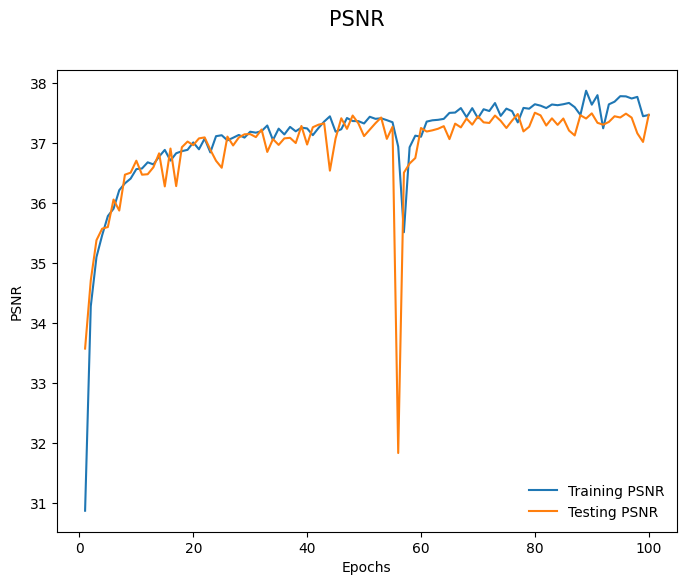

In [14]:
import matplotlib.pyplot as plt
x = [i for i in range(1,101)]
fig, ax = plt.subplots(1, figsize=(8,6))
fig.suptitle("PSNR", fontsize = 15)
ax.set_xlabel('Epochs')
ax.set_ylabel('PSNR')
ax.plot(x, train_psnr, label="Training PSNR")
ax.plot(x, test_psnr, label="Testing PSNR")
plt.legend(loc="lower right", frameon=False)
plt.show()

In [15]:
torch.save(model.module.state_dict(), 'model_unetnd_denoise_256.pth')